<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/Machete_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machete Series Temporales

## Imortamos Librerias

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

# Ignorar las advertencias específicas de statsmodels
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.filterwarnings('ignore', category=ValueWarning)

## Cargamos el Dataset

In [26]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Air Pasangers
id = '1L2Ww1zULOaJauVF370DFAziq_Mu19nj9'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('AirPassengers.csv')
data = pd.read_csv('AirPassengers.csv') # Cargamos el Dataset
##############################################################################
# Time Searies Example (Drug Sales)
id = '1LIadGzbG8QbZvYmxTRTkAL1Mzk9CcOG7'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('TimeSeries.csv')
data_drugs = pd.read_csv('TimeSeries.csv') # Cargamos el Dataset
bk_data_drugs = data_drugs.copy()

In [27]:
# url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/Index2018.csv'
# raw_csv_data = pd.read_csv(url)
# data = raw_csv_data.copy()

print(data.info())
display(data.head(13))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


## Pre-Procesamiento
- Periodo: Frecuencia con la que se repite un patrón en la serie temporal
- Lag: Distancia temporal entre dos observaciones

In [28]:
# Convert the 'Month' column to a datetime data type
data['Mes'] = pd.to_datetime(data['Month'])

# Set the 'Month' column as the index of the dataframe
data.set_index('Mes', inplace=True)

# Deberia setear la frecuencia?
data.index.freq='MS' # Depende como este formateado Date
# data = data.asfreq('M') # O puede estar incompleta

# Adaptamos distintas frecuencias temporales
# display(data.asfreq('b').head()) # Business Day
# data.asfreq('d').head() # Completa dias faltantes con null
# data.asfreq('m').head() # Mes
# data.resample(rule='QS').max # Agrupa por Cuartos, y muestra el Max de cada uno

# Una vez transformada a Index y renombrada a Mes, eliminamos la variable Month
data.drop(columns='Month', inplace=True)

# Renombramos la variable #Passengers
data.rename(columns={'#Passengers':'Pasajeros'}, inplace=True)

print(data.info())
display(data.head(13))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Pasajeros  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


,Pasajeros
Mes,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


## Visualizacion de la Serie Original

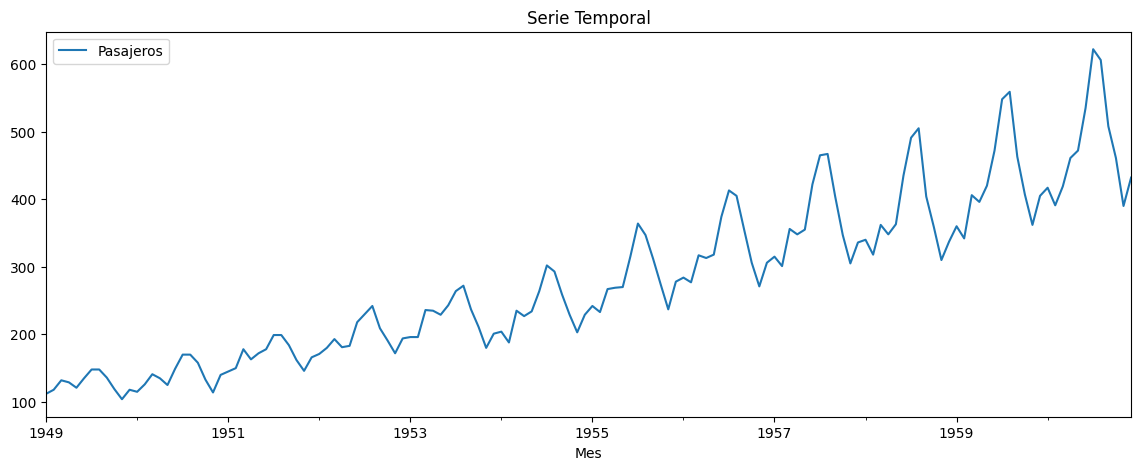

In [33]:
# Visualizamos
data.plot(figsize=(14, 5), title='Serie Temporal')
# plt.show()

data.to_csv('AirPassengers_std.csv', index=True)

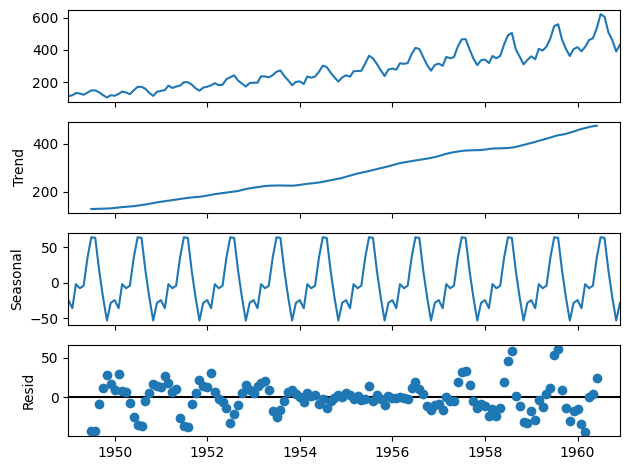

In [32]:
# Descomposicion de la Serie
from statsmodels.tsa.seasonal import seasonal_decompose

data_dec = seasonal_decompose(data, model = "adittive") # Multiplicativo es mas apto cuando hay ceros o negativos
data_dec.plot()
plt.show()

**Observado**: Muestra los datos originales de la serie temporal, que en este caso son los pasajeros mensuales.

**Tendencia**: Indica la tendencia a largo plazo de los datos, eliminando las fluctuaciones estacionales y el ruido aleatorio. En este caso, parece haber una tendencia ascendente a lo largo del tiempo, lo que sugiere un aumento en el número de pasajeros a lo largo de los años.

**Estacionalidad**: Muestra el patrón estacional dentro de los datos, que se repite con regularidad. La estacionalidad parece ser bastante consistente a lo largo del tiempo, lo que indica que hay un patrón estacional claro, probablemente relacionado con los ciclos de viaje durante el año.

**Residuo**: Representa el ruido o las irregularidades en los datos después de eliminar la tendencia y la estacionalidad. Los residuos parecen ser bastante pequeños en comparación con la tendencia y la estacionalidad, lo que sugiere que el modelo aditivo ha capturado la mayor parte de la información en los datos originales.

## Analisis de Estacionariedad

In [50]:
# Funciones Auxiliares para el Analisis Analitco de Estacionariedad
# Mepa que es lo mismo que ADFTest de  pmdarima

from statsmodels.tsa.stattools import adfuller

def estacioneriedad(y):
  resultado = adfuller(y)
  # print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  # print('Valores criticos:')
  # for key, valor in resultado[4].items():
  #   print('\t%s: %.3f' % (key, valor))
  if resultado[1] < 0.05:
    print('Serie Estacionaria')
  else:
    print('Serie no Estacionaria')

p-valor: 0.991880
Serie no Estacionaria
None


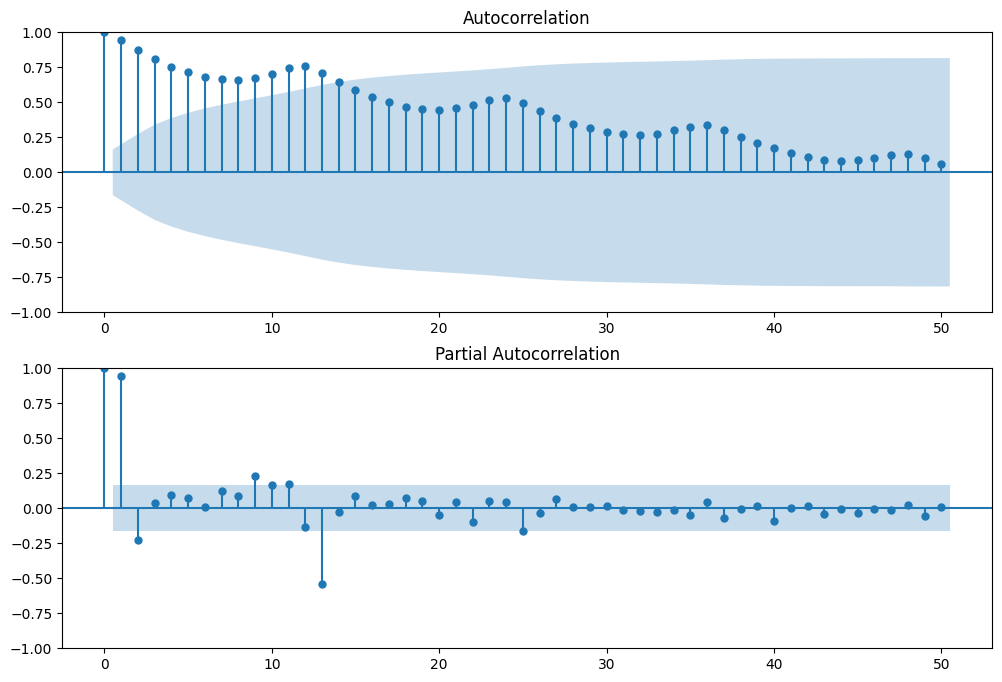

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Funcion Auxiliar del analisis de Estacionariedad
print(estacioneriedad(data))

# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data, lags=50, ax=ax1)
plot_pacf(data, lags=50, ax=ax2)
plt.show()

**ACF (Autocorrelation Function)**: Muestra la correlación de la serie consigo misma en diferentes lags. Si la serie fuera estacionaria, esperaríamos que las autocorrelaciones se redujeran rápidamente a cero. Sin embargo, en esta gráfica, las autocorrelaciones se mantienen significativas (fuera del área azul sombreada que representa el intervalo de confianza) para muchos lags, lo que sugiere que la serie no es estacionaria.

**PACF (Partial Autocorrelation Function)**: Muestra la correlación parcial de la serie consigo misma, controlando por las correlaciones de todos los lags más cortos. La PACF corta bruscamente después del primer lag, lo que es típico de una serie que necesita ser diferenciada para alcanzar la estacionariedad.

El **Test Analitico de Augmented Dickey–Fuller**, tambien nos indica que la serie es No-Estacionaria

## Diferenciacion de la Serie Original

In [65]:
# Funciones Auxiliares para en Analsis Analitico de Diferenciacion

from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from pmdarima.arima import ADFTest

def diferenciacion(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)


  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  # print('Se debe realizar diferenciación (should_diff) ADF Test')
  # adftest = ADFTest(alpha=0.05)
  # print(adftest.should_diff(y))

Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con PP test
0


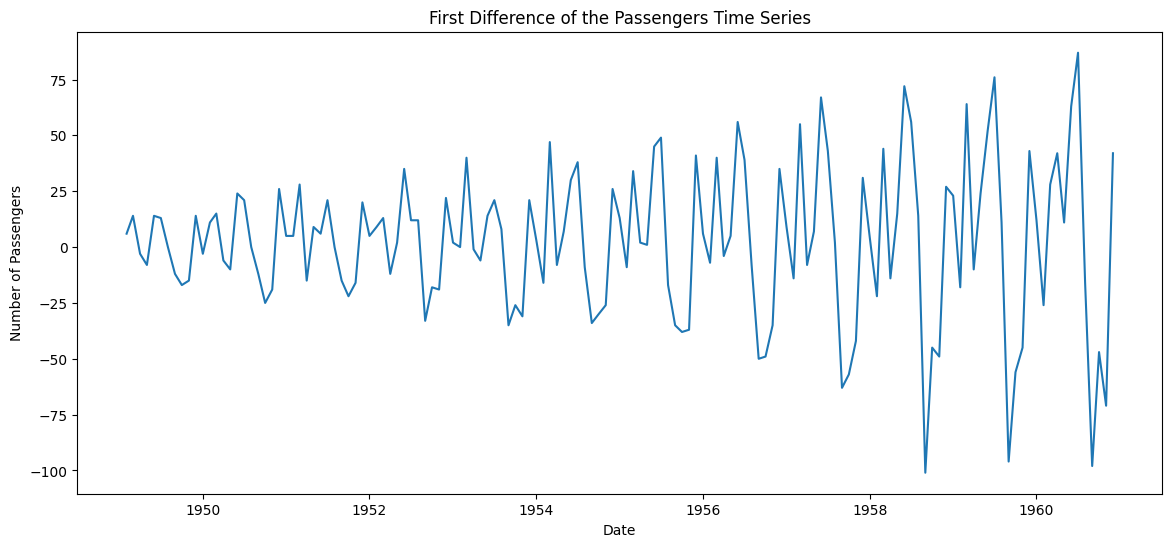

In [66]:
# Distintos Test Analiticos para determinar el orden de Diferenciacion recomendados
diferenciacion(data)

# Apply first difference
data_diff = data['Pasajeros'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(14,6))
plt.plot(data_diff)
plt.title('First Difference of the Passengers Time Series')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

**Variaciones alrededor de cero**: La serie diferenciada oscila alrededor de una media que parece ser cercana a cero, lo cual es un indicio de que la tendencia ha sido eliminada. Esto es un buen signo de que la diferenciación ha ayudado a estabilizar la media de la serie temporal.

**Disminución de la varianza**: No hay un patrón claro de aumento o disminución de la varianza a lo largo del tiempo, lo que sugiere que la diferenciación también ha ayudado a estabilizar la varianza de la serie temporal.

**Patrones estacionales**: Aunque la tendencia se ha eliminado, todavía se pueden observar patrones estacionales. Esto se evidencia por los picos y valles regulares que persisten después de la diferenciación. Estos patrones indican que aún puede haber estacionalidad en los datos que no ha sido abordada por la primera diferencia.

**Ausencia de tendencia**: No hay una tendencia ascendente o descendente clara en la serie diferenciada, lo que sugiere que la primera diferencia fue efectiva en eliminar la tendencia lineal de la serie original.

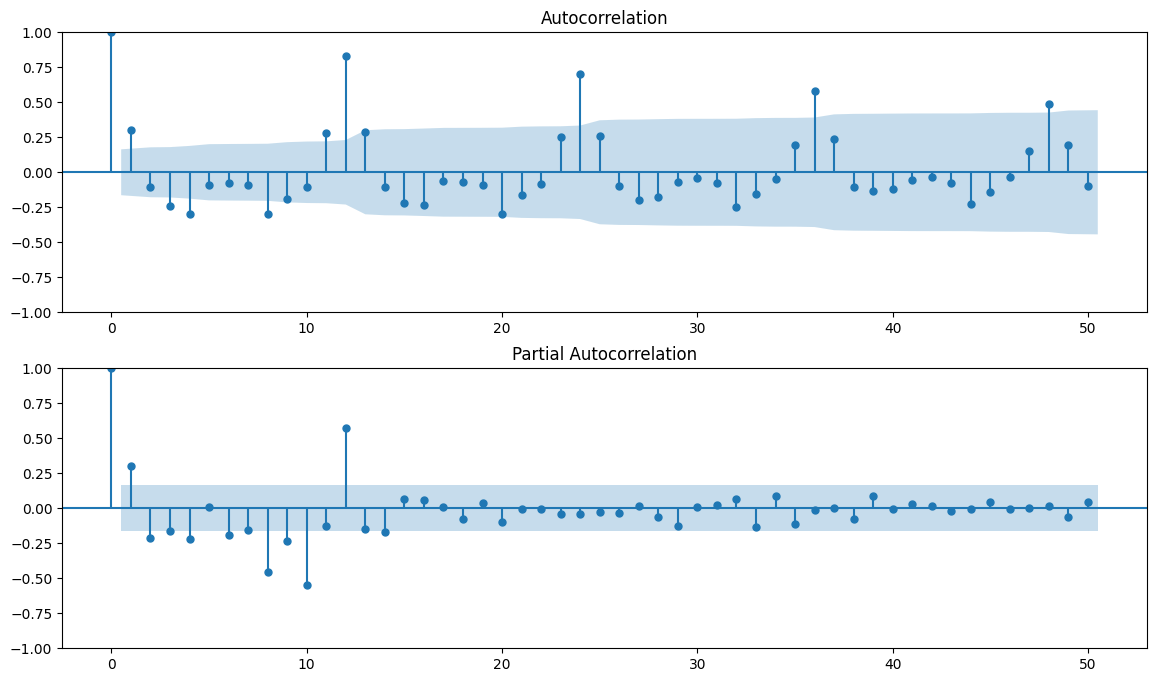

In [40]:
# Plot the ACF and PACF for the differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(data_diff, lags=50, ax=ax1)
plot_pacf(data_diff, lags=50, ax=ax2)
plt.show()

**ACF (Autocorrelation Function)**: La función de autocorrelación muestra que hay algunos picos significativos en los primeros lags y luego se reduce, pero no decae inmediatamente a cero, lo que sugiere que todavía hay cierta correlación estacional en los datos. Tambien se observan los picos Estacionales, con un periodo de 12

**PACF (Partial Autocorrelation Function)**: La función de autocorrelación parcial muestra picos significativos en los primeros lags y luego se corta, lo que es indicativo de un posible orden AR (autoregresivo) para un modelo ARIMA.

Estos patrones en las gráficas ACF y PACF sugieren que, aunque la primera diferencia ha ayudado a eliminar la tendencia, todavía puede haber estacionalidad en los datos que podría necesitar ser modelada. Además, los picos en la PACF podrían indicar que un modelo ARIMA con componentes autoregresivos podría ser apropiado para estos datos.

## Modelo ARMA
- Solo para series ya Estacionarias
- Para un modelo ARMA(p,q), p es el último lag significativo en la PACF, y q es el último lag significativo en la ACF.

In [41]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARMA model. Here we need to specify the order (p, d, q).
# Since we have already differenced the data once, d=0 in this ARIMA model.
# We will start with p=1 and q=1, which are common starting points.
model = ARIMA(data_diff, order=(1, 0, 1))
results = model.fit()

# Display the summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Pasajeros   No. Observations:                  143
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -694.061
Date:                Sun, 05 Nov 2023   AIC                           1396.122
Time:                        01:03:52   BIC                           1407.973
Sample:                    02-01-1949   HQIC                          1400.937
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4507      3.441      0.712      0.476      -4.293       9.195
ar.L1         -0.4767      0.128     -3.735      0.000      -0.727      -0.227
ma.L1          0.8645      0.080     10.743      0.000       0.707       1.022
sigma2       958.5228    107.063      8.953      0.000     748.683    1168.363
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.64   Prob(JB):                         0.34
Heteroskedasticity (H):               7.01   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Coeficientes**: El coeficiente para el término autoregresivo (AR) es -0.4767 y para el término de media móvil (MA) es 0.8645. Ambos son significativos, como lo indica el valor p (P>|z|) que es menor que 0.05.

**AIC y BIC**: El Criterio de Información de Akaike (AIC) es 1396.122 y el Criterio de Información Bayesiano (BIC) es 1407.973. Estos valores se utilizan para comparar modelos; en general, un valor más bajo indica un mejor modelo, tomando en cuenta la complejidad y el ajuste.

**Pruebas de Diagnóstico**:

- **La prueba de Ljung-Box (Q)** tiene un valor p de 0.64, lo que indica que no hay autocorrelaciones significativas en los residuos, es decir, los residuos parecen ser ruido blanco
- **La prueba de Heteroscedasticidad (H)** tiene un valor p muy bajo, lo que sugiere que hay heteroscedasticidad en los residuos.
- **La prueba de Jarque-Bera (JB)** tiene un valor p de 0.34, lo que indica que los residuos tienen una distribución normal.

## Modelo Auto-ARIMA
- Al ser la Serie Orignal No-Estacionaria, el parametro d nos indicaria la cantidad de diferenciaciones recomendadas

In [ ]:
# Usando la libreria pmdarima
# !pip install pmdarima
from pmdarima.arima import auto_arima

# Configuración inicial para p, d, q
start_p = 1  # Valor inicial de p
start_q = 1  # Valor inicial de q
max_p = 6    # Máximo valor de p a considerar
max_q = 6   # Máximo valor de q a considerar
d = None     # Diferenciación (si se establece en None, auto_arima la determinará)
max_d = 2    # Máximo número de diferenciaciones no estacionales


# Ejecutar auto_arima
model = auto_arima(data, start_p=start_p, start_q=start_q,
                   max_p=max_p, max_q=max_q, max_d=max_d,
                   seasonal=False,  # No estacionalidad
                   trace=True,      # Imprimir resultados
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)   # Utilizar el algoritmo stepwise

# Imprimir el resumen del modelo
print(model.summary())

In [103]:
# # Probando distintos p, d, q
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Define the p, d, and q parameters to take any value between 0 and x
p = q = range(9, 13)
d = range(1, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Define a DataFrame to store the results
results_df = pd.DataFrame(columns=['pdq', 'aic'])

# Run a grid search over all pdq combinations
for param in pdq:
    try:
        temp_model = ARIMA(data, order=param)
        results = temp_model.fit()

        # Store results
        results_df = results_df.append({'pdq': param, 'aic': results.aic}, ignore_index=True)
    except Exception as e:
        # Store the exception message
        results_df = results_df.append({'pdq': param, 'aic': str(e)}, ignore_index=True)

# Sort the results by AIC and return the best combination
results_df.sort_values('aic', inplace=True)
results_df.head()

,pdq,aic
20,"(11, 2, 9)",1144.590920
21,"(11, 2, 10)",1145.985111
22,"(11, 2, 11)",1148.939368
24,"(12, 1, 9)",1151.184608
13,"(10, 2, 10)",1152.101403


## Metodologia Box-Jenkings

### **Paso 1: Identificación**
Diferenciación: Si la serie temporal no es estacionaria, necesitamos diferenciarla. Esto ya lo hemos hecho previamente con tu serie temporal.
ACF y PACF: Examinamos los gráficos ACF y PACF para determinar los posibles valores de p y q.



In [107]:
# Paso 1: Identificación
estacioneriedad(data_diff)

# Suponemos que con una diferenciacino de 1 es suficiente
# Tambien deberiamos anlizar las graficas de ACF y PACF

p-valor: 0.054213
Serie no Estacionaria


### **Paso 2: Estimación**
Ajuste del Modelo: Ajustamos un modelo ARIMA con los valores de p, d, y q identificados en el paso anterior. Esto se puede hacer con la función ARIMA de statsmodels.

In [122]:
# Paso 2: Estimación

# Ajustamos un modelo ARIMA con los valores iniciales de p, d, q basados en los gráficos ACF y PACF
model = ARIMA(data_diff, order=(1,0,1))
model_fit = model.fit()

### **Paso 3: Diagnóstico**


#### **Coeficientes**: Verificamos que los coeficientes del modelo son signific

In [126]:
# Paso 3: Diagnóstico

# Imprimimos el resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Pasajeros   No. Observations:                  143
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -694.061
Date:                Sun, 05 Nov 2023   AIC                           1396.122
Time:                        03:29:20   BIC                           1407.973
Sample:                    02-01-1949   HQIC                          1400.937
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4507      3.441      0.712      0.476      -4.293       9.195
ar.L1         -0.4767      0.128     -3.735      0.000      -0.727      -0.227
ma.L1          0.8645      0.080     10.743      0.0

- El coeficiente para el término AR (ar.L1) es -0.4767 y es estadísticamente significativo (p < 0.05)
- El coeficiente para el término MA (ma.L1) es 0.8645 y también es estadísticamente significativo (p < 0.05)

#### **Gráficos de Residuos**: Examinamos los gráficos de los residuos para asegurarnos de que parecen ruido blanco.


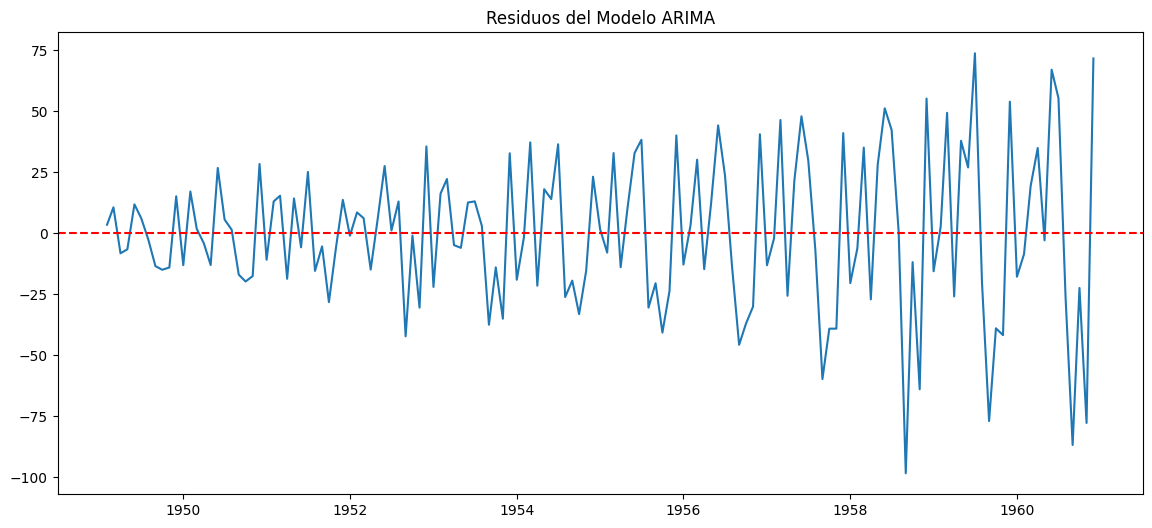

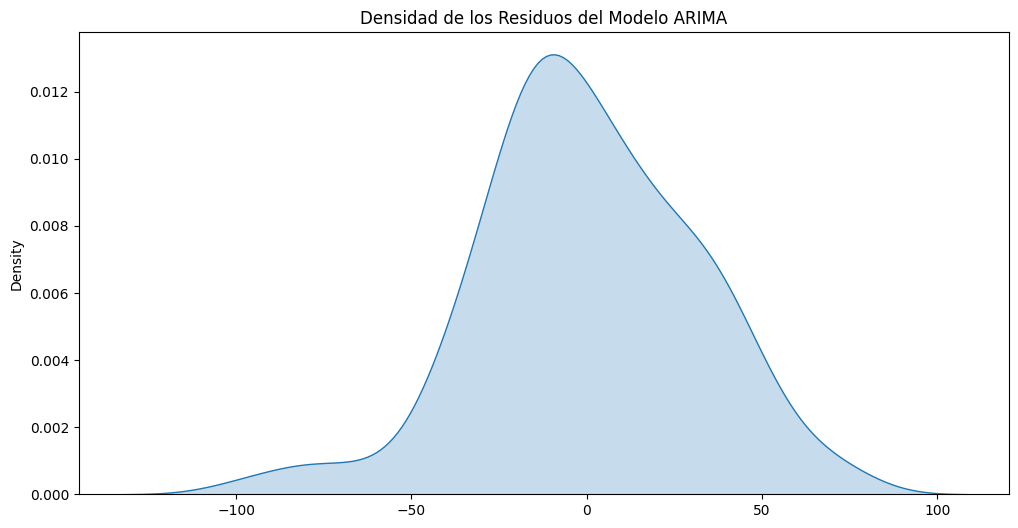

In [128]:
# Vamos a realizar un diagnóstico del modelo para verificar la adecuación
residuals = model_fit.resid

# Gráfico de los residuos
plt.figure(figsize=(14,6))
plt.plot(residuals)
plt.title('Residuos del Modelo ARIMA')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Densidad de los residuos
plt.figure(figsize=(12,6))
plt.title('Densidad de los Residuos del Modelo ARIMA')
sns.kdeplot(residuals, shade=True)
plt.show()

- El gráfico de los residuos muestra que están centrados alrededor de cero y no parecen tener una estructura o patrón claro, lo cual es bueno.
- La densidad de los residuos parece seguir una distribución normal, lo que sugiere que los residuos se comportan como ruido blanco.

#### **Prueba de Ljung-Box**: Realizamos la prueba de Ljung-Box en los residuos para buscar autocorrelaciones significativas.

In [129]:
# Paso 3: Diagnóstico
from statsmodels.stats.diagnostic import acorr_ljungbox

# Realizamos la prueba de Ljung-Box en los residuos para buscar autocorrelaciones significativas
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print('Resultados de la prueba de Ljung-Box:')
print(ljung_box_results)

Resultados de la prueba de Ljung-Box:
      lb_stat  lb_pvalue
10  31.590241   0.000468


- La estadística de prueba para 10 rezagos es aproximadamente 31.59, y el p-valor asociado es 0.000468, lo cual es menor que el nivel de significancia típico de 0.05.
- Esto indica que hay autocorrelación significativa en los residuos a 10 rezagos, lo que sugiere que el modelo ARIMA(1,0,1) puede no ser adecuado para los datos.
- Podríamos considerar ajustar un modelo diferente, posiblemente con diferentes valores de p y q, o incluir términos estacionales si sospechamos que hay estacionalidad en los datos